<font size="12">Lidar Model</font>

<font size="6"> Import libraries</font>

In [25]:
import os
import torch
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

<font size="6">Read Data & Convert to Tensors</font>

In [26]:

# Read data, convert to PyTorch tensors
data_samples = "lidar.csv"
data = pd.read_csv(data_samples, header=None)
X = data.iloc[:, 0:16].values
y = data.iloc[:, 16].values

trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

<font size="6">Choosing the device to run the model</font>

<font size="2">If cuda is used, it will run your model faster than using your device memory</font>

In [27]:

# use Cuda Y/N 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


<font size="6">Neural Network construction</font>

<font size="2">We can use any number of hidden layers but its better to choose the layers by first experimenting with different number of layers. Also in our model we have used ReLU as our softening function </font>

In [28]:

#Neural Network construction
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, outputs),
            
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

<font size="6">Model Training</font>

<font size="2">In our model we have 16 input feartures(sensors) and  single output. We have to keep experimenting with different learning rates and epochs until we get the lowest loss value. The lower the loss function the better the model is. Here we have used mini batch to feed for every epoch.</font> 

In [29]:


#model Training


model = NeuralNetwork(16, 1)

epochs = 200
batch_size = 64
learningRate = 0.008
losses = []

lossFunction = nn.MSELoss()
gradientDescent = torch.optim.Adam(model.parameters(), lr=learningRate)

loader = DataLoader(
    dataset=torch.utils.data.TensorDataset(trainingSetX, trainingSetY),
    batch_size=batch_size,
    shuffle=True
)



for epoch in range(epochs):
    epoch_loss = 0.0
    for x, y in loader:
       
        gradientDescent.zero_grad()
        yhat = model(x)
        loss = lossFunction(yhat, y)
        epoch_loss += loss.item()
        loss.backward()
        gradientDescent.step()
    losses.append(epoch_loss / len(loader))




<font size="6">Machine Learning flow(ML flow)</font>

<font size="2">Ml Flow helps in racking component allows you to record machine model training sessions (called runs) & run queries</font>

In [30]:
#Machine Learning Flow

sensor = "lidar"
hidden_layers = "64_32"
activation = "ReLU_ReLU"
batch_size = "64"

mlflow.set_experiment('NeuralNetwork')

# with mlflow.start_run(run_name=f'Neural net ({sensor}) | layers: {len(hidden_layers)}, epochs: {epochs}, lr: {lr}, batchsize: {batch_size}'):
with mlflow.start_run(run_name=f'NN({sensor}) {hidden_layers}, epochs: {epochs}, lr: {learningRate}, batch_size =    {batch_size}'):


    mlflow.log_param('sensor', sensor)
    mlflow.log_param('data_samples', data_samples)
    
    mlflow.log_param('hidden_layers', hidden_layers)
    mlflow.log_param('activation', activation)

    mlflow.log_param('epochs', epochs)
    mlflow.log_param('lr', learningRate)
    mlflow.log_param('batch_size', batch_size)

    mlflow.log_param('optimizer', gradientDescent)
    mlflow.log_param('loss_fn', lossFunction)
    mlflow.log_metric('losses', losses[-1])


<font size="6">Saving the Model</font>

<font size="2">We are saving the model using pytorch but actually pytorch itself uses the module pickle to save the model.</font>

In [31]:
# Saving Model
with open('SDCar_Lidar.pth', 'wb') as f:
    torch.save(model.linear_relu_stack, f)

<font size="6">Plotting the Loss functiuon against the epochs</font>

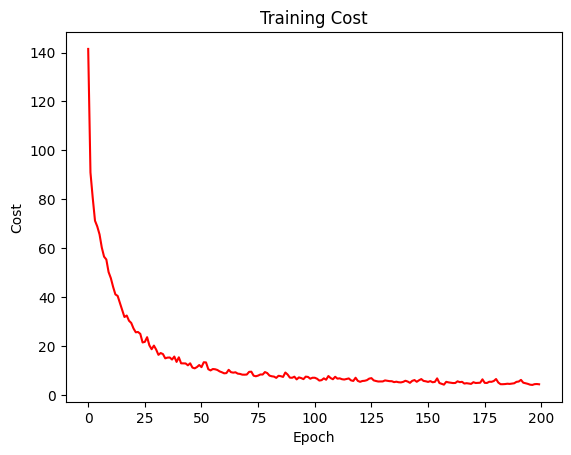

In [32]:
# Compare
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")
plt.plot([x for x in range(epochs)], losses, 'red')
plt.show()